# L-shape single cut 算法求解随机优化
参考 Ntaimo L. Computational Stochastic Programming: Models, Algorithms, and Implementation, Vol. 774[M]. Cham: Springer International Publishing, 2024.


## 模型结构
书中给出的两阶段随机优化的示例模型为
$$
\begin{aligned}
&\min_{\mathbf{x},\mathbf{y}}{\mathbf{c}^{\mathrm{T}}\mathbf{x}+\sum_{s=1}^S{p(\omega^s)\varphi(\mathbf{x},\omega^s)}}\\
s.t. & \mathbf{Ax}>=\mathbf{b}\\
& \mathbf{x}>=0
\end{aligned}
$$
其中$\varphi(\mathbf{x},\omega^s)$为
$$
\begin{aligned}
&\min_{\mathbf{y}}{\mathbf{q}^{\mathrm{T}}\mathbf{y}(\omega^s)}\\
s.t. & \mathbf{W}\mathbf{y}(\omega^s)>=\mathbf{r}(\omega^s)-\mathbf{T}\mathbf{x}\\
& \mathbf{y}(\omega^s)>=0
\end{aligned}
$$

## Benders 分解single cut 直接迭代算法
本节采取单割方法进行直接迭代，即最优割为各场景的概率加权和，可行割则为子循环中第一个不可行的场景

首先进行参数的定义

In [2]:
using JuMP, Gurobi
import MathOptInterface as MOI
# parameters
# first stage
const c=[50,30,15,10]
const A=[-1 0 0 0;0 -1 0 0;0 0 -1 0;0 0 0 -1;0 -1 -1 -1]
const b=[-300,-700,-600,-500,-1600]
# second stage
const S=5
const p=[0.15,0.3,0.3,0.2,0.05]
const q=[-1150,-1525,-1900]
const W=[-6 -8 -10;-20 -25 -28;-12 -15 -18;-8 -10 -14;-1 0 0;0 -1 0;0 0 -1]
const T=[1 0 0 0;0 1 0 0;0 0 1 0;0 0 0 1;0 0 0 0;0 0 0 0;0 0 0 0]
const r1=[0,0,0,0,-15,-10,-5]
const r2=[0,0,0,0,-25,-20,-15]
const r3=[0,0,0,0,-25,-20,-25]
const r4=[0,0,0,0,-30,-25,-30]
const r5=[0,0,0,0,-10,-10,-10]
const r=[r1,r2,r3,r4,r5]
const max_iter=30

30

根据书中的流程，首先不考虑二阶段约束，只针对一阶段进行优化得到一个初始解

In [3]:
function initial_x()
    m=Model(Gurobi.Optimizer)
    set_silent(m)
    @variable(m, x0[1:4]>=0)
    @objective(m,Min,c'*x0)
    @constraint(m,A*x0.>=b)
    optimize!(m)
    return value.(x0)
end

initial_x (generic function with 1 method)

而后进行添加割平面的函数定义

In [4]:
function add_cut!(MP,x_value)
    β=zeros((4,))#割平面斜率
    β0=0#截距
    obj=0#子问题目标函数
    for s in 1:S
        SP=Model(Gurobi.Optimizer)
        set_silent(SP)
        set_attribute(SP,"InfUnbdInfo",1)
        set_attribute(SP,"DualReductions",0)#为了在子问题不可行时获得极射线，需要对gurobi进行上述两个参数设置
        @variable(SP,y[1:3]>=0)
        @objective(SP,Min, q'*y)
        @constraint(SP,cons, W*y.>=r[s]-T*x_value)
        optimize!(SP)
        if termination_status(SP)!=MOI.OPTIMAL
            println("Subproblem $s is infeasible, adding feasibility cut")
            unbd_ray=dual.(cons)#获取极射线
            β=vec(unbd_ray'*T)
            β0=unbd_ray'*r[s]
            @constraint(MP, β'*x>= β0)#添加可行割
            return (is_opt=false,uk=obj)
        else
            duals=dual.(cons)
            β+=vec(p[s]*duals'*T)
            β0+=p[s]*duals'*r[s]
            obj+=p[s]*objective_value(SP)
        end
    end
    new_con=@constraint(MP,β'*x+η>=β0)#添加最优割
    println("Adding optimality cut $new_con")
    return (is_opt=true,uk=obj+c'*x_value)
end

add_cut! (generic function with 1 method)

而后初始化主问题并进行第一次迭代

In [5]:
MP=Model(Gurobi.Optimizer)
set_silent(MP)
@variable(MP, x[1:4]>=0)
@variable(MP,η)
@objective(MP, Min, c'*x+η)
@constraint(MP,A*x.>=b)
# add initial cut
result=add_cut!(MP,initial_x())
optimize!(MP)
u_history=[]
l_history=[]
# iterative process
k=0
l=-Inf
u=Inf
ϵ=0.1
if result.is_opt
    u=min(u,result.uk)
end
l=max(l,objective_value(MP))
push!(u_history,u)
push!(l_history,l)

Set parameter LicenseID to value 2632898
Set parameter LicenseID to value 2632898
Set parameter LicenseID to value 2632898
Set parameter LicenseID to value 2632898
Set parameter LicenseID to value 2632898
Set parameter LicenseID to value 2632898
Set parameter LicenseID to value 2632898
Adding optimality cut 191.66666666666666 x[1] + η ≥ 0


1-element Vector{Any}:
 -42500.0

继续进行迭代直到收敛

In [6]:
while k<max_iter && u-l>ϵ
    global k+=1
    println("Iteration $k: Lower bound=$l, Upper bound=$u")
    x_value=value.(x)
    println(x_value)
    res=add_cut!(MP,x_value)
    optimize!(MP)
    global l=max(l,objective_value(MP))
    if res.is_opt
        global u=min(u,res.uk)
    end
    push!(u_history,u)
    push!(l_history,l)
end

Iteration 1: Lower bound=-42500.0, Upper bound=0.0
[300.0, 0.0, 0.0, 0.0]
Set parameter LicenseID to value 2632898
Set parameter LicenseID to value 2632898
Set parameter LicenseID to value 2632898
Set parameter LicenseID to value 2632898
Set parameter LicenseID to value 2632898
Adding optimality cut 67.85714285714285 x[2] + η ≥ 0
Iteration 2: Lower bound=-14108.695652173905, Upper bound=0.0
[247.82608695652172, 700.0, 0.0, 0.0]
Set parameter LicenseID to value 2632898
Set parameter LicenseID to value 2632898
Set parameter LicenseID to value 2632898
Set parameter LicenseID to value 2632898
Set parameter LicenseID to value 2632898
Adding optimality cut 105.55555555555554 x[3] + η ≥ 0
Iteration 3: Lower bound=-7358.695652173905, Upper bound=0.0
[247.82608695652172, 700.0, 450.0, 0.0]
Set parameter LicenseID to value 2632898
Set parameter LicenseID to value 2632898
Set parameter LicenseID to value 2632898
Set parameter LicenseID to value 2632898
Set parameter LicenseID to value 2632898
Add

In [7]:
println("Final solution after $k iterations: Lower bound=$l, Upper bound=$u")
println("Optimal first stage decision variables:")
for i in 1:4
    println("x[$i] = ", value(x[i]))
end

Final solution after 19 iterations: Lower bound=-2268.5000000000073, Upper bound=-2268.5
Optimal first stage decision variables:
x[1] = 236.4000000000001
x[2] = 690.0
x[3] = 432.0
x[4] = 318.0000000000003


可视化收敛过程

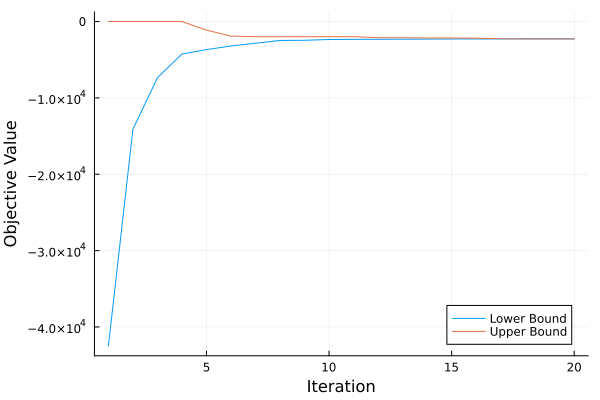

In [8]:
using Plots
plot(l_history, label="Lower Bound", xlabel="Iteration", ylabel="Objective Value", legend=:bottomright)
plot!(u_history, label="Upper Bound")